In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LogisticRegression:
    def __init__(self,
                 epochs=100,
                 lr=0.1,
                 use_bias=True):
        """Logistic Regression

        Args:
            epochs (int, optional): Epochs. Defaults to 100.
            lr (float, optional): Learning Rate. Defaults to 0.1.
            use_bias (bool, optional): Bias Term. Defaults to True.
        """
        self.epochs = epochs
        self.weights = None
        self.bias = 0
        self.lr = lr
        self.use_bias = use_bias
        self.n_features = 0
    
    def _sigmoid_function(self, x):
        # To avoid overflow issue
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)
        
    def _sigmoid(self, x):
        return np.array([self._sigmoid_function(value) for value in x])
        
    def _compute_loss(self, y_true, y_pred):
        # loss = -y_true*log(y_pred)-(1-y_true)*log(1-y_pred)
        # Added 1e-9 to avoid log(0)
        loss = y_true * np.log(y_pred + 1e-9)
        loss += (1-y_true) * np.log(1 - y_pred + 1e-9)
        return -1*np.mean(loss)
    
    def _compute_derivate_w(self, X, y_true, y_pred):
        # derivative w.r.t w using chain rule X^T * (y_true - y_pred)
        #
        #     h = w^T * X
        #     z = σ(h) = 1/(1+e^−h)
        #     J(w) = −(y * log(z) + (1−y) * log(1−z))
        #
        #     ∂J(w)/∂w = (∂J(w)/∂z)*(∂z/∂h) * (∂h/∂w)
        #     ∂J(w)/∂z = −((y/z) − ((1−y)/(1−z))) = (z−y)/(z(1−z))
        #     ∂z/∂h = z(1−z)
        #     ∂h/∂w = X
        #     ∂J(w)/∂w = X^T * (z−y)
        derivative = (np.dot(X.T, (y_true-y_pred)))/len(y_true)
        return derivative
        
    def _compute_derivative_b(self, y_true, y_pred):
        # derivative w.r.t to b = (1/n) * (y_true - y_pred)
        return np.mean(y_true-y_pred)
    
    def _plot_loss(self, losses):
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(range(self.epochs), losses, 'm', linewidth="5")
        plt.show()

    def fit(self, X, y, verbose=False, plot_loss=False):
        """Fit

        Args:
            X : Features
            y : Target
            verbose (bool, optional): controls logging. Defaults to False.
            plot_loss (bool, optional): Plots loss vs epochs if true. Defaults to False.
        """
        assert X.shape[0] == len(y), "Number of rows in X, y doesn't match"
        
        self.n_features = X.shape[1]
        self.weights = np.random.randn(self.n_features)
        losses = []
        
        for epoch in range(self.epochs):
            y_pred = self._sigmoid(np.dot(X, self.weights) + self.bias)
            loss = self._compute_loss(y, y_pred)
            losses.append(loss)
            grad_w = self._compute_derivate_w(X, y, y_pred)
            self.weights += self.lr*grad_w
            if self.use_bias:
                grad_b = self._compute_derivative_b(y, y_pred)
                self.bias += self.lr*grad_b
            if verbose:
                print(f"Epoch: {epoch} Loss: {loss}")
            
        if plot_loss:
            self._plot_loss(losses)
    
    def predict_proba(self, X):
        """Predict

        Args:
            X : Features

        Returns:
            np.array : Predictions probabilities
        """
        assert X.shape[1] == self.n_features, \
                f"Expected {self.n_features} features but got {X.shape[1]}"
        
        return self._sigmoid(np.dot(X, self.weights)+self.bias)
    
    def predict(self, X, thresh=0.5):
        """Predict

        Args:
            X : Features
            thresh : Threshold. Defaults to 0.5.
        Returns:
            np.array : Predictions 
        """
        assert X.shape[1] == self.n_features, \
                f"Expected {self.n_features} features but got {X.shape[1]}"
        
        probabilities = self._sigmoid(np.dot(X, self.weights)+self.bias)
        return [1 if p > thresh else 0 for p in probabilities]

In [3]:
#Generate data
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=5, random_state=11)
print(X.shape, y.shape)

(200, 2) (200,)


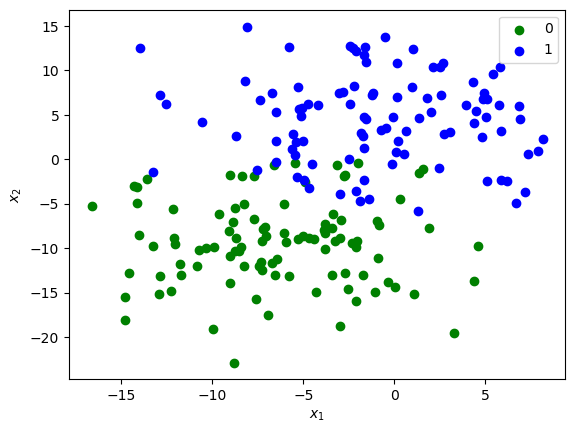

In [4]:
plt.scatter(*X[y==0].T, color='g', label='0')
plt.scatter(*X[y==1].T, color='b', label='1')
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')
plt.legend()
plt.show()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                test_size=0.2,
                                                shuffle=True,
                                                stratify=y,
                                                random_state=35)
print(X_train.shape, X_val.shape)

(160, 2) (40, 2)


## Logistic Regression

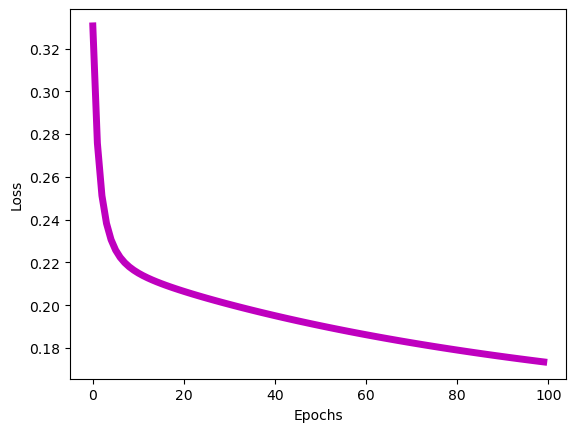

In [6]:
model = LogisticRegression(epochs=100)
model.fit(X_train, y_train, verbose=False, plot_loss=True)

In [7]:
def plot_decision_boundary(weights, bias):
    # Retrieve model parameters.
    b = bias
    w1, w2 = weights

    # Calculate the intercept and gradient of the decision boundary.
    c = -b/w2
    m = -w1/w2

    # Plot the data and the classification with the decision boundary.
    xmin, xmax = X[0].min()-10, X[0].max()+3
    ymin, ymax = X[1].min()-10, X[1].max()+3

    xd = np.array([xmin, xmax])
    yd = m*xd + c

    plt.plot(xd, yd, 'k', lw=1, ls='--')
    plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.5)
    plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.5)

    plt.scatter(*X[y==0].T, alpha=0.9)
    plt.scatter(*X[y==1].T, alpha=0.9)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')

    plt.show()

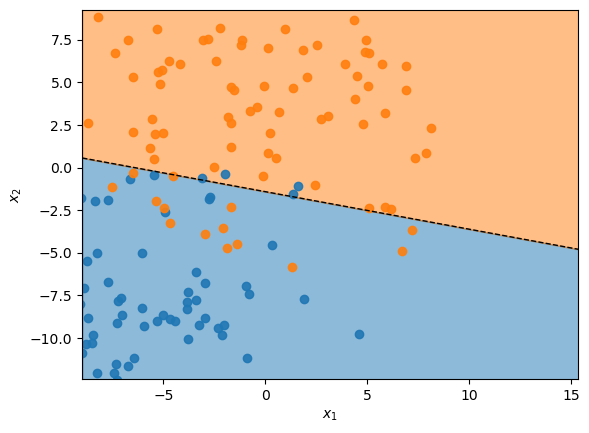

In [8]:
plot_decision_boundary(model.weights, model.bias)

In [9]:
print('Train accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Validation accuracy: ', accuracy_score(y_val, model.predict(X_val)))

Train accuracy:  0.90625
Validation accuracy:  0.9


## Scikit-Learn API

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

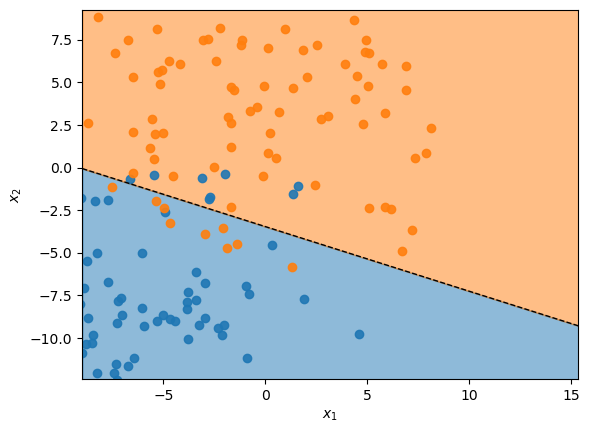

In [11]:
plot_decision_boundary(model.coef_.T, model.intercept_[0])

In [12]:
print('Train accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Validation accuracy: ', accuracy_score(y_val, model.predict(X_val)))

Train accuracy:  0.91875
Validation accuracy:  0.875
